- Nama  : Karunia Perjuangan Mustadl'Afin
- NIM   : 20/456368/TK/50498
- Prodi : Teknologi Informasi

<h3 style="text-align:center">Mendeteksi Wajah dengan Memanfaatkan Algoritma Histogram of Oriented Gradients + Support Vector Machine</h3>

Object Detection adalah salah satu tugas sebuah komputer dalam bidang Visi Komputer yang memiliki tujuan mengetahui keberadaan suatu benda yang secara spesifik ada dalam suatu kelas (misal mobil atau manusia).

Pada saat ini, rata-rata implementasi Object Detection sudah memakai algoritma Deep Learning seperti YOLO dan Vision Transformers. Algoritma DL seperti itu tidak memerlukan ekstraksi fitur tertentu karena sudah bisa ditelusuri otomatis oleh sistem.

Lain halnya pada beberapa tahun yang lalu. Saat teknologi Deep Learning belum sepopuler sekarang, orang-orang harus mencari fitur dari suatu gambar yang bisa diolah oleh komputer. Salah satu cara mencari fitur tersebut adalah Histogram of Oriented Gradients. Bila fitur tersebut telah ditemukan dalam bentuk vektor, proses klasifikasi dan deteksi objek tentunya akan menjadi lebih mudah dilakukan.

### A. Persiapan

Karena kita menggunakan Google Colab, set dahulu direktorinya ke tempat proyek kita

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('./drive/MyDrive/PCVK Midterm Project/')

Seperti biasa, `import` terlebih dahulu _library-library_ yang akan digunakan:

In [ ]:
#Menyesuaikan versi library yang ada di Local PC saya
!pip install -U -q scikit-learn==1.0.2 Pillow==9.4.0

In [ ]:
import numpy as np #Digunakan untuk melakukan operasi matematis
from PIL import Image # Digunakan untuk membaca dan mengolah gambar
import matplotlib.pyplot as plt # Digunakan untuk menampilkan gambar
from skimage import draw # Digunakan untuk menggambar garis
import os # Digunakan untuk mengakses file
from typing import List, Union # Digunakan untuk memudahkan Interpreter Python
from tqdm import tqdm # Digunakan untuk menampilkan progress bar
from random import sample, shuffle # Digunakan untuk mengacak data
import pickle # Digunakan untuk menyimpan model

### B. Histogram of Oriented Gradients

Histogram of Oriented Gradients adalah salah satu _feature descriptor_ yang ada dalam Visi Komputer. Seperti namanya, algoritma ini berfokus pada sebuah Histogram yang masing-masing batangnya adalah "arah" dari perubahan intensitas (gradien) dari suatu daerah dalam gambar.

Untuk lebih jelasnya, lihat gambar berikut:

![](https://www.researchgate.net/publication/318134187/figure/fig1/AS:578366711111685@1514904777612/Formation-of-the-histogram-of-oriented-gradients-descriptor.png)

Sebagai awalan pembuatan HoG, kita perlu membuat suatu _helper function_ yang berguna mencari gradien dari suatu gambar. Gradien ini didefinisikan sebagai perubahan kecerahan piksel dari suatu titik ke titik yang lain. Untuk itu, fungsi ini akan menghitung gradien dari segi horizontal dan segi vertikal. Caranya cukup mudah, yaitu cukup dengan mengurangi nilai kecerahan pada suatu gambar dengan nilai kecerahan pada gambar yang digeser 1 atau 2 piksel sesuai sumbunya.

In [ ]:
# HoG Gradient
# Untuk menghitung gradient dari gambar
def hog_gradient(image:np.ndarray):
    """
    Parameter:
    image: (M, N) array = Gambar grayscale
    
    Return:
    g_row: (M, N) array = Gradient terhadap baris
    g_col: (M, N) array = Gradient terhadap kolom
    
    """
    g_row = np.zeros_like(image)
    g_col = np.zeros_like(image)

    g_row[1:-1, :] = image[2:, :] - image[:-2, :] # Mengurangi nilai pixel sebuah baris dengan nilai pixel baris sebelumnya
    g_col[:, 1:-1] = image[:, 2:] - image[:, :-2] # Mengurangi nilai pixel sebuah kolom dengan nilai pixel kolom sebelumnya

    return g_row, g_col

![](https://customers.pyimagesearch.com/wp-content/uploads/2015/03/hog_cell_magnitude.jpg)

Selanjutnya, kita ingin membuat histogram dari gradien tersebut. Maka, kita membuat _helper function_ lagi, namun saat ini kita akan mencari histogram dari gradien yang sudah dihitung.

Secara sepintas, kode di bawah terlihat panjang. Namun, bila kita pahami lebih lanjut, logika kode ini mudah dipahami. Kita mencari dahulu magnitude dan orientasi/sudut gradien dengan memanfaatkan aturan trigonometri. Lalu, kita memecah histogram menjadi beberapa yang dikelompokkan berdasarkan sudut orientasinya yang berada dalam kisaran 0$^\circ$-180$^\circ$ (Biasanya ada 9 bagian). Untuk masing-masing sel, kita menjumlahkan semua magnitude piksel yang ada dalam sel tersebut ke dalam kelompok-kelompok sudut orientasi yang ada di histogram.

In [ ]:
def hog_histograms(gradient_columns,
                   gradient_rows,
                   cell_columns, cell_rows,
                   size_columns, size_rows,
                   number_of_cells_columns, number_of_cells_rows,
                   number_of_orientations, ):


    """Extract Histogram of Oriented Gradients (HOG) for a given image.
    Parameters
    ----------
    gradient_columns : ndarray
        First order image gradients (rows).
    gradient_rows : ndarray
        First order image gradients (columns).
    cell_columns : int
        Pixels per cell (rows).
    cell_rows : int
        Pixels per cell (columns).
    size_columns : int
        Number of columns.
    size_rows : int
        Number of rows.
    number_of_cells_columns : int
        Number of cells (rows).
    number_of_cells_rows : int
        Number of cells (columns).
    number_of_orientations : int
        Number of orientation bins.
    orientation_histogram : ndarray
        The histogram array which is modified in place.
    """
    orientation_histogram = np.zeros((number_of_cells_rows, number_of_cells_columns, number_of_orientations))
    magnitude = np.hypot(gradient_columns, gradient_rows)
    orientation = np.rad2deg(np.arctan2(gradient_rows, gradient_columns)) % 180
    
    number_of_orientations_per_180 = 180. / number_of_orientations

    for i in range(number_of_orientations):
        orientation_start = number_of_orientations_per_180 * (i + 1)
        orientation_end = number_of_orientations_per_180 * i

        for r in range((cell_rows // 2), cell_rows * number_of_cells_rows, cell_rows):
            if r + (cell_rows + 1) // 2 > size_rows:
                break

            for c in range(cell_columns // 2, cell_columns * number_of_cells_columns, cell_columns):
                if c + (cell_columns + 1) // 2 > size_columns:
                    break

                total = 0.0

                for cell_row in range(-(cell_rows // 2), ((cell_rows + 1) // 2)):
                    cell_row_index = r + cell_row
                    if (cell_row_index < 0 or cell_row_index >= size_rows):
                        continue

                    for cell_column in range(-(cell_columns // 2), (cell_columns + 1) // 2):
                        cell_column_index = c + cell_column
                        if (cell_column_index < 0 or cell_column_index >= size_columns
                                or orientation[cell_row_index, cell_column_index] >= orientation_start
                                or orientation[cell_row_index, cell_column_index] < orientation_end):
                            continue

                        total += magnitude[cell_row_index, cell_column_index]

                orientation_histogram[r // cell_rows, c // cell_columns, i] = total / (cell_rows * cell_columns)
    return orientation_histogram

Kode di bawah menggambarkan jalannya algoritma hog secara lengkap. Penjelasan lebih lanjut ada di komentar kode.

In [ ]:
#Histogram of Oriented Gradients Algorithm
def hog(image:np.ndarray, cell_size:tuple=(8,8), block_size:tuple=(2,2), nbins:int=9, signed_gradient:bool=True,already_grayscale=False, visualize=True):
    
    """
    Fungsi ini digunakan untuk mengekstrak fitur HOG dari gambar.
    Fitur yang telah diekstrak akan digunakan untuk melakukan klasifikasi gambar.
    Algoritma klassifikasi yang digunakan bisa bermacam-macam, seperti SVM, Random Forest, atau Neural Network.
    
    Tahapan yang dilakukan:
    1. Mengubah gambar dari RGB ke grayscale jika belum
    2. Normalisasi gambar untuk meningkatkan performa algoritma
    3. Menghitung gradient dari gambar di setiap 'baris' dan 'kolom' dengan menghitung selisih gambar dengan gambar yang sama, namun ditranslasi
    4. Menghitung histogram dari masing-masing sel
    5. Menormalisasi histogram untuk setiap blok
    6. Menggabungkan histogram dari setiap blok menjadi satu vektor fitur
    7. Membuat visualisasi dari HoG
    8. Mengembalikan vektor fitur dan visualisasi
    
    Parameter:
    image: gambar yang akan diekstrak fiturnya
    cell_size: jumlah pixel untuk setiap sel
    block_size: jumlah sel untuk setiap blok
    nbins: jumlah orientations bins
    signed_gradient: apakah gradient memiliki tanda plus minus atau tidak
    
    Return:
    features: vektor fitur dengan dimensi 1 x (n_blocks_row* n_blocks_col* n_cells_row* n_cells_col* nbins)
    hog_image: visualisasi dari HoG
    """
    
    # Kita perlu memastikan bahwa gambar adalah matriks 2 Dimensi dan semua elemennya berada dalam rentang 0-1.
    image  = np.atleast_2d(image)
    if image.dtype != np.float64:
        image = (image / 255.).astype(np.float64, copy=False)
    
    #Jika gambar tidak hitam putih, buat ia hitam putih
    if not already_grayscale:
        image = np.mean(image, axis=2)
    
    g_rows, g_cols = hog_gradient(image)
    
    s_rows, s_cols = image.shape[:2] # ukuran gambar
    c_rows, c_cols = cell_size # ukuran sel
    b_rows, b_cols = block_size # ukuran blok
    
    n_cells_row = s_rows // c_rows  # Jumlah sel di setiap baris
    n_cells_col = s_cols // c_cols  # Jumlah sel di setiap kolom
    
    # Pada bagian ini, kita membuat histogram dengan helper function yang sudah dijelaskan sebelumnya
    cell_histogram = hog_histograms(g_cols, g_rows, c_cols, c_rows, s_cols, s_rows,
                                    n_cells_col, n_cells_row, nbins)
    
    # Menghitung histogram untuk setiap blok
    n_blocks_row = (n_cells_row - b_rows) + 1
    n_blocks_col = (n_cells_col - b_cols) + 1

    #Histogram yang sudah dibuat perlu dinormalisasi agar lebih stabil. Pada implementasi kode ini, kita menggunakan normalisasi L-2
    normalized_blocks = np.zeros((n_blocks_row, n_blocks_col, b_rows, b_cols, nbins))
    eps = 1e-5 # epsilon untuk menghindari pembagian dengan nol
    for r in range(n_blocks_row):
        for c in range(n_blocks_col):
            block = cell_histogram[r:r + b_rows, c:c + b_cols, :] #Melihat nilai pada block
            normalized_blocks[r, c, :] = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
            
    # Menggabungkan/Meratakan histogram dari setiap blok menjadi satu vektor fitur  dengan dimensi 1 x (n_blocks_row* n_blocks_col* n_cells_row* n_cells_col* n_orient) agar bisa diproses dengan algoritma klasifikasi lain
    features = normalized_blocks.ravel()
    
    if visualize:
        # Membuat gambar klasifikasi
        hog_image = None   
        radius = min(c_rows, c_cols) // 2 - 1
        orientations_arr = np.arange(nbins)
        # set dr_arr, dc_arr to correspond to midpoints of orientation bins
        orientation_bin_midpoints = (
            np.pi * (orientations_arr + .5) / nbins)
        dr_arr = radius * np.sin(orientation_bin_midpoints)
        dc_arr = radius * np.cos(orientation_bin_midpoints)
        hog_image = np.zeros_like(image)
        for r in range(n_cells_row):
            for c in range(n_cells_col):
                for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                    centre = tuple([r * c_rows + c_rows // 2,
                                    c * c_cols + c_cols // 2])
                    rr, cc = draw.line(int(centre[0] - dc),
                                        int(centre[1] + dr),
                                        int(centre[0] + dc),
                                        int(centre[1] - dr))
                    hog_image[rr, cc] += cell_histogram[r, c, o]   
                    
        return features, hog_image
    else:
        return features, None

Selanjutnya, kita akan mengambil contoh gambar dan hasil ekstraksi fitur HoG-nya

In [ ]:
example_image = Image.open('arteta.png')
#resize image
example_image = example_image.resize((64,128), Image.LANCZOS)
#greyscale image
example_image = example_image.convert('L')

example_image = np.array(example_image)

hog_features, hog_image = hog(example_image, cell_size=(8, 8), block_size=(2, 2), nbins=9, signed_gradient=False, already_grayscale=True)

Berikut ini adalah hasil visualisasi HoG yang dipisahkan berdasarkan sel gambar dan gambar aslinya.

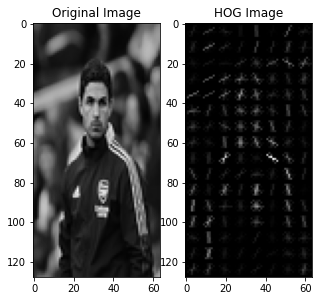

In [ ]:
ax, fig = plt.subplots(1,2, figsize=(5,5))
fig[0].imshow(example_image, cmap='gray')
fig[0].set_title('Original Image')
fig[1].imshow(hog_image, cmap='gray')
fig[1].set_title('HOG Image')

plt.show()

### C. Dataset

Untuk mencegah dataset ditrain ulang saat Run All, saya sengaja membuat error di sini agar pengguna bisa menskip bagian training

In [1]:
assert (1 + 1 == 3, "Perhatian! Kode berhenti secara otomatis. Lanjutkan bagian di bawah jika anda ingin melakukan training atau langsung skip di bagian Sliding Window jika anda sudah memiliki modelnya")

<>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-1-4191ef85ff23>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (1 + 1 == 3, "Perhatian! Kode berhenti secara otomatis. Lanjutkan bagian di bawah jika anda ingin melakukan training atau langsung skip di bagian Sliding Window jika anda sudah memiliki modelnya")


Kita akan melakukan pengolahan gambar. Ada dua kelas, yaitu wajah dan bukan wajah. Gambar wajah saya ambil dari gambar wajah yang sudah diproses dalam dataset kumpulan wajah orang, sementara gambar bukan wajah saya ambil dari gambar pemandangan.

In [ ]:
def show_sample_folder(folder_path, n=5):
    """
    Fungsi ini digunakan untuk menampilkan beberapa gambar dari folder yang diinginkan.
    """
    plt.figure(figsize=(10, 10))
    list_files = os.listdir(folder_path)
    shuffle(list_files)
    for i, file in enumerate(list_files[:n]):
        plt.subplot(1, n, i+1)
        img = Image.open(os.path.join(folder_path, file))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

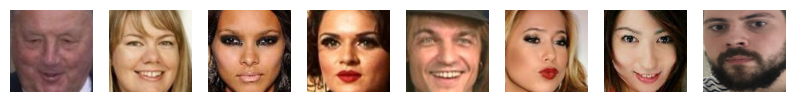

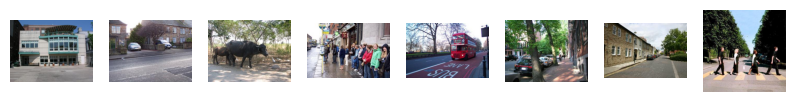

In [ ]:
show_sample_folder('./Dataset/face-raw/',n=8)
show_sample_folder('./Dataset/non-face-raw/',n=8)

Agar model bisa lebih fleksibel, kita akan melakukan scaling dan cropping secara acak.

In [ ]:
def random_crop(image:Image.Image,cropped_size=(64,128),scaling:List[int]=[1], face=False):
    """
    Fungsi ini digunakan untuk melakukan random crop pada gambar.
    scaling dibuat list agar fungsi bisa mengacak berapa skala dari gambar yang dicrop
    """

    scale = sample(scaling,1)[0]
    
    #Karena gambar asli berukuran 128x128, jika scaling==1, gambar akan tercrop secara 
    if face and (scale ==1):
        return image.resize(cropped_size, Image.LANCZOS)
    
    image = image.resize((image.size[0]*scale,image.size[1]*scale), Image.LANCZOS)
    
    width, height = image.size

    new_width, new_height = cropped_size
    
    left = np.random.randint(0, width - new_width)
    top = np.random.randint(0, height - new_height)
    right = left + new_width
    bottom = top + new_height
    return image.crop((left, top, right, bottom))

Pada data aslinya, jumlah gambar bukan wajah 4x lebih sedikit dari gambar wajah. Untuk itu, kita perlu menyeimbangkan data tersebut agar masing-masing kelas memiliki keseragaman jumlah data.

In [ ]:
nonface_multiplier = 4
# Membuat dataset kumpulan gambar non-face yang sudah dicrop
if not os.path.exists('./Dataset/non-face/'):
    os.mkdir('./Dataset/non-face/')
count = 0
nonface_list = os.listdir('./Dataset/non-face-raw/')
shuffle(nonface_list)


for file in nonface_list:
    #Range multiplier digunakan untuk menghasilkan beberapa gambar yang berbeda dari satu gambar asli
    for i in range(nonface_multiplier):
        image = Image.open(os.path.join('./Dataset/non-face-raw/', file))
        image = random_crop(image,scaling=[1,2])
        image.save(os.path.join('./Dataset/non-face/', f'{count}.jpg'))
        count += 1

In [ ]:
face_multiplier = 1
# Membuat dataset kumpulan gambar face yang sudah dicrop
if not os.path.exists('./Dataset/face/'):
    os.mkdir('./Dataset/face/')
count = 0

face_list = os.listdir('./Dataset/face-raw/')
shuffle(face_list)


for file in face_list:
    #Range multiplier digunakan untuk menghasilkan beberapa gambar yang berbeda dari satu gambar asli
    for i in range(face_multiplier):
        image = Image.open(os.path.join('./Dataset/face-raw/', file))
        image = random_crop(image,scaling=[1,2], face=True)
        image.save(os.path.join('./Dataset/face/', f'{count}.jpg'))
        count += 1


Berikut contoh dataset yang sudah diproses.

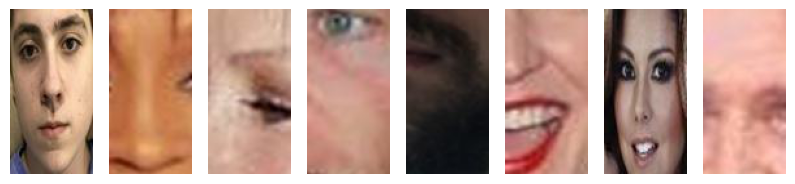

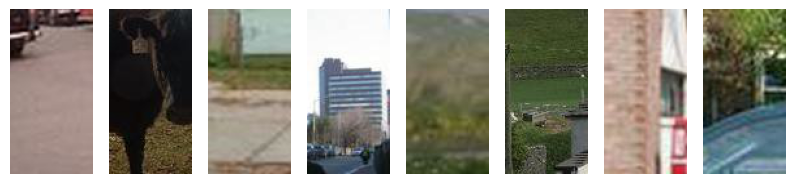

In [ ]:
show_sample_folder('./Dataset/face/',n=8)
show_sample_folder('./Dataset/non-face/',n=8)

## D. Klasifikasi (SVM)

Support Vector Machine adalah salah satu _classifier_ yang populer di Machine Learning. Cara kerja SVM adalah membuat hyperspace pembatas kelas yang memiliki dimensi 1 tingkat lebih rendah dari dimensi ruang vektor. Letak dan arah hyperspace ini bisa dioptimalisasi dengan berbagai algoritma, seperti Lagrange Multiplier dkk.

SVM tidak terlalu dibahas panjang lebar karena sudah dibahas di kelas Kecerdasan Buatan. Dengan demikian, kode SVM ini tidak diimplementasikan secara mendetail, namun melalui library _scikit-learn_. Kode yang sudah dibuat ini berupa vektor, sehingga bisa diolah dengan mudah oleh algoritma SVM.

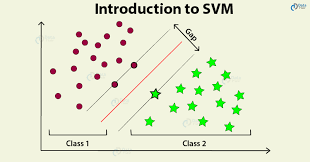

Kita perlu mendefinisikan dahulu fungsi untuk mengubah gambar mejadi vektor fitur.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def Image2FeatureVector(image:Union[Image.Image,np.array]) -> np.ndarray:
    """Mengubah gambar menjadi vektor fitur"""
    
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    image = image.resize((64,128), Image.Resampling.LANCZOS) # Resize gambar agar sesuai dengan ukuran input HoG
    image = image.convert('L') # Membuat gambar menjadi grayscale
    image = np.array(image)

        
    features, _ = hog(image, cell_size=(8, 8), block_size=(2, 2), nbins=9, signed_gradient=False, already_grayscale=True,visualize=False)
    return features

Setelah kode jadi, kita bisa membuat data masukan dan data label dengan mengubah semua gambar yang ada di dalam folder menjadi kumpulan vektor yang bisa dibaca model. Proses training ini sama dengan proses klasifikasi tabular karena setiap dimensi vektor dapat diibaratkan sebagai setiap kolom pada tabel data.

In [ ]:
### Load Dataset for SVM

folder = './Dataset'

"""
Kelas non-face = 0
Kelas face = 1
"""
categories = ['non-face','face']

data = []
labels = []
for category in categories:
    path = os.path.join(folder, category)
    label = categories.index(category)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = Image.open(img_path)
        features = Image2FeatureVector(image)
        data.append(features)
        labels.append(label)
    

100%|██████████| 2994/2994 [01:07<00:00, 44.47it/s]


In [ ]:
data, labels = np.array(data), np.array(labels)

In [ ]:
print(data.shape, labels.shape)

(5854, 3780) (5854,)


Kita perlu memecah data yang sudah dibuat menjadi 2 bagian : training dan test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=456368)

Pembuatan model dengan SVM ada di bagian ini. Kita gunakan kernel rbf agar bentuk _hyperspace_ lebih fleksibel.

In [ ]:
model = SVC(kernel='rbf',probability=True)
model.fit(X_train, y_train)

SVC(probability=True)

Dengan mengevaluasi model, kita dapatkan akurasi pada dataset tes.

In [ ]:
model.score(X_test, y_test)

0.9496157130657558

In [ ]:
pickle.dump(model, open('svm_classification_model.pkl','wb'))

### E. Sliding Window For Object Detection

Untuk mendeteksi adanya benda pada suatu gambar, kita perlu mengevaluasi setiap bagian yang ada di gambar. Dengan Deep Learning, hal tersebut mudah dilakukan. Lain halnya dengan SVM. Karena tidak bisa secara langsung mengevaluasi gambar, kita perlu memecah gambar menjadi beberapa bagian yang masing-masing kita lakukan prediksi.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#Mendefinisikan ulang untuk berjaga-jaga jika bagian Training tidak dirun
def Image2FeatureVector(image:Union[Image.Image,np.array]) -> np.ndarray:
    """Mengubah gambar menjadi vektor fitur"""
    
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    image = image.resize((64,128), Image.Resampling.LANCZOS) # Resize gambar agar sesuai dengan ukuran yang diinginkan
    image = image.convert('L') # Membuat gambar menjadi grayscale
    image = np.array(image)

        
    features, _ = hog(image, cell_size=(8, 8), block_size=(2, 2), nbins=9, signed_gradient=False, already_grayscale=True,visualize=False)
    return features

Jangan lupa load lagi model yang sudah kita simpan di Google Drive

In [ ]:
#Load model
model = pickle.load(open('svm_classification_model.pkl','rb'))

Di sini, kita membuat heatmap untuk masing-masing piksel dengan cara memprediksi output model klasifikasi pada setiap _sliding window_ yang bergeser secara perlahan-lahan ke seluruh bagian gambar. Dalam setiap kelompok piksel yang besarnya ditentukan _step size_, akan dihitung berapa kotak yang mencangkupi piksel tersebut.
Untuk _window size_ nya, kita akan gunakan ukuran yang sama dengan saat kita melakukan _training_ dan ekstraksi fitur, yaitu (64,128)

Kita juga mengeset gambar sehingga berukuran (640,512). Hal ini dilakukan agar resolusi gambar keseluruhan menjadi kelipatan _window size_

In [ ]:
# Define a single function that can extract features using sliding window technique and return the heatmap of mask
def predict_face(image:Image,step_size=32,confidence_threshold=0.8):
    image = image.resize((640, 512), Image.Resampling.LANCZOS).convert('L')
    window_size = (64, 128)

    heatmap = np.zeros((image.height, image.width))
    # Membuat sliding window
    for y in range(0, image.height-window_size[1], step_size):
        for x in range(0, image.width-window_size[0], step_size):
            window = image.crop((x, y, x + window_size[0], y + window_size[1]))
            features = Image2FeatureVector(window)
            prediction = model.predict_proba([features])[0][1]
            #Jika prediksi model bernilai di atas threshold, seluruh piksel heatmap yang berada dalam window nilainya bertambah 1
            if float(prediction) > confidence_threshold:
                rx, ry = draw.rectangle((x, y), extent=window_size, shape=heatmap.shape)
                heatmap[ry, rx] += 1


    
    #normalize heatmap
    heatmap = heatmap / np.max(heatmap)
    return heatmap

In [ ]:
def compare_prediction_and_image(path):
    image = Image.open(path).resize((640, 512), Image.LANCZOS)
    heatmap = predict_face(image)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[1].imshow(heatmap, cmap='gray')
    ax[1].set_title('Heatmap')
    ax[0].set_title('Image')
    plt.show()

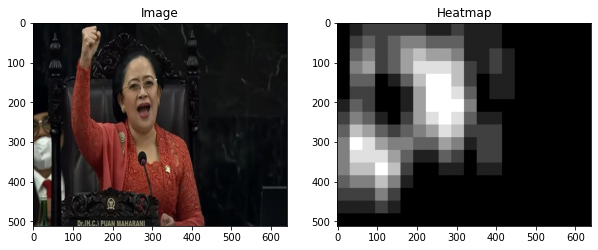

In [ ]:
compare_prediction_and_image('puan.webp')

Dari gambar di atas, terlihat bahwa daerah sekitar muka akan lebih sering dinyatakan positif oleh model.

Kita juga bisa mengunggah gambar kustom untuk diprediksi (Jika memanfaatkan Google Colab)

In [ ]:
from google.colab import files

Saving rhae.jpg to rhae (2).jpg


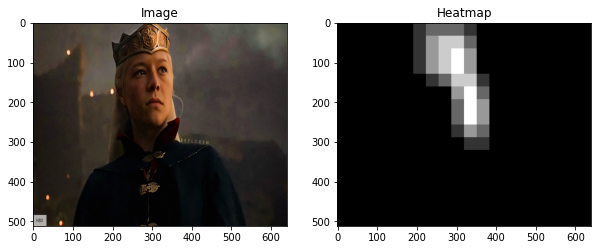

In [ ]:
hasil = files.upload()
nama_file = next(iter(hasil))
compare_prediction_and_image(nama_file)

Referensi :
1. https://github.com/sunsided/viola-jones-adaboost/blob/master/viola-jones.ipynb (Pemilihan Dataset, terutama untuk Non Face)
2. https://www.kaggle.com/datasets/andrewmvd/face-mask-detection (Dataset untuk yang Face)
3. https://github.com/hangyao/Udacity_SDCND_Vehicle-Detection
4. https://github.com/scikit-image/scikit-image (Implementasi Algoritma HoG)
5. https://pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/